<a href="https://colab.research.google.com/github/ppajewski/Stock-Price-Predictions-Using-Ridge-Regression-LSTM-ANN/blob/master/Stock_Price_Predictions_Using_Ridge_Regression_%26_LSTM_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the dataset and libraries

In [ ]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras
import pandas_datareader.data as web
import datetime as dt

In [ ]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime.now()
stock_info_df = web.DataReader("AAPL", 'yahoo', start, end)
stock_info_df["Date"] = stock_info_df.index
stock_info_df['index'] = range(len(stock_info_df.index))
stock_info_df.set_index('index', inplace=True)
print(stock_info_df.head())

            High        Low       Open  ...       Volume  Adj Close       Date
index                                   ...                                   
0      27.860001  26.837500  27.847500  ...  212818400.0  24.941502 2015-01-02
1      27.162500  26.352501  27.072500  ...  257142000.0  24.238857 2015-01-05
2      26.857500  26.157499  26.635000  ...  263188400.0  24.241146 2015-01-06
3      27.049999  26.674999  26.799999  ...  160423600.0  24.581060 2015-01-07
4      28.037500  27.174999  27.307501  ...  237458000.0  25.525522 2015-01-08

[5 rows x 7 columns]


In [ ]:
# Read stock prices data
stock_price_df = stock_info_df[['Date', 'Close']]
# Sort the data based on Date
stock_price_df = stock_price_df.sort_values(by = ['Date'])
# Check if Null values exist in stock prices data
stock_price_df.isnull().sum()
# Get stock prices dataframe info
stock_price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447 entries, 0 to 1446
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1447 non-null   datetime64[ns]
 1   Close   1447 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.9 KB


In [ ]:
# Read the stocks volume data
stock_vol_df = stock_info_df[['Date', 'Volume']]
# Sort the data based on Date
stock_vol_df = stock_vol_df.sort_values(by = ['Date'])
# Check if Null values exist in stocks volume data
stock_vol_df.isnull().sum()
# Get stock volume dataframe info
stock_vol_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447 entries, 0 to 1446
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1447 non-null   datetime64[ns]
 1   Volume  1447 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.9 KB


In [ ]:
stock_vol_df.describe()

,Volume
count,1.447000e+03
mean,1.437544e+08
std,6.992528e+07
min,4.199410e+07
25%,9.606500e+07
50%,1.275316e+08
75%,1.720558e+08
max,6.488252e+08


#Data analysis and visualization

In [ ]:
# Function to normalize stock prices based on their initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

In [ ]:
# Function to plot interactive plots using Plotly Express
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = df['Date'], y = df[i], name = i)
  fig.show()

In [ ]:
# plot interactive chart for stocks data
interactive_plot(stock_price_df, 'Stock Prices')

# Data Preprocessing

In [ ]:
# Function to concatenate the date, stock price, and volume in one dataframe
def individual_stock(price_df, vol_df):
    return pd.DataFrame({'Date': price_df['Date'], 'Close': price_df['Close'], 'Volume': vol_df['Volume']})

In [ ]:
# Function to return the input/output (target) data for AI/ML Model
# Note that our goal is to predict the future stock price 
# Target stock price today will be tomorrow's price 
def trading_window(data):
  
  # 1 day window 
  n = 1

  # Create a column containing the prices for the next 1 days
  data['Target'] = data[['Close']].shift(-n)
  
  # return the new dataset 
  return data

In [ ]:
# Let's test the functions and get individual stock prices and volumes
price_volume_df = individual_stock(stock_price_df, stock_vol_df)
price_volume_df

,Date,Close,Volume
index,,,
0,2015-01-02,27.332500,212818400.0
1,2015-01-05,26.562500,257142000.0
2,2015-01-06,26.565001,263188400.0
3,2015-01-07,26.937500,160423600.0
4,2015-01-08,27.972500,237458000.0
...,...,...,...
1442,2020-09-24,108.220001,167743300.0
1443,2020-09-25,112.279999,149981400.0
1444,2020-09-28,114.959999,137672400.0


In [ ]:
price_volume_target_df = trading_window(price_volume_df)
# Remove the last row as it will be a null value
price_volume_target_df = price_volume_target_df[:-1]
price_volume_target_df

,Date,Close,Volume,Target
index,,,,
0,2015-01-02,27.332500,212818400.0,26.562500
1,2015-01-05,26.562500,257142000.0,26.565001
2,2015-01-06,26.565001,263188400.0,26.937500
3,2015-01-07,26.937500,160423600.0,27.972500
4,2015-01-08,27.972500,237458000.0,28.002501
...,...,...,...,...
1441,2020-09-23,107.120003,150718700.0,108.220001
1442,2020-09-24,108.220001,167743300.0,112.279999
1443,2020-09-25,112.279999,149981400.0,114.959999


In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
price_volume_target_scaled_df = sc.fit_transform(price_volume_target_df.drop(columns = ['Date']))

In [ ]:
# Creating Feature and Target
X = price_volume_target_scaled_df[:, :-1]
y = price_volume_target_scaled_df[:, -1]

In [ ]:
# Spliting the data this way, since order is important in time-series
# Note that we did not use train test split with it's default settings since it shuffles the data
split = int(0.75 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

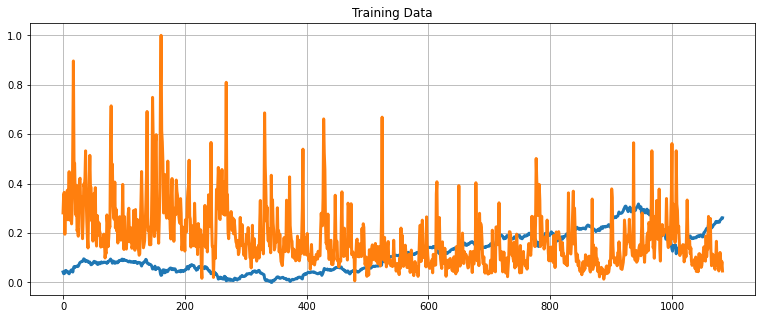

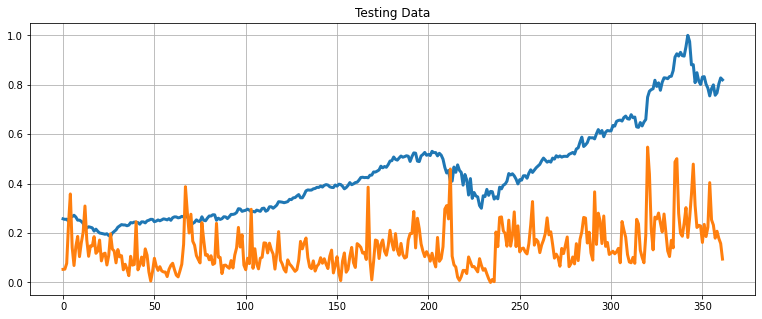

In [ ]:
# Define a data plotting function
def show_plot(data, title):
  plt.figure(figsize = (13, 5))
  plt.plot(data, linewidth = 3)
  plt.title(title)
  plt.grid()

show_plot(X_train, 'Training Data')
show_plot(X_test, 'Testing Data')


# Ridge Linear Regression Model

In [ ]:
from sklearn.linear_model import Ridge
# Note that Ridge regression performs linear least squares with L2 regularization.
# Create and train the Ridge Linear Regression  Model
regression_model = Ridge()
regression_model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
# Test the model and calculate its accuracy 
lr_accuracy = regression_model.score(X_test, y_test)
print("Linear Regression Accuracy: ", lr_accuracy)

Linear Regression Accuracy:  0.912314260904508


In [ ]:
# Make Prediction
predicted_prices = regression_model.predict(X)

In [ ]:
# Append the predicted values into a list
Predicted = []
for i in predicted_prices:
  Predicted.append(i)

In [ ]:
# Append the close values to the list
close = []
for i in price_volume_target_scaled_df:
  close.append(i[0])


In [ ]:
# Create a dataframe based on the dates in the individual stock data
df_predicted = price_volume_target_df[['Date']]
df_predicted['Close'] = close
df_predicted['Prediction'] = Predicted
df_predicted

,Date,Close,Prediction
index,,,
0,2015-01-02,0.042542,0.050769
1,2015-01-05,0.035642,0.042946
2,2015-01-06,0.035665,0.042708
3,2015-01-07,0.039003,0.049959
4,2015-01-08,0.048277,0.054650
...,...,...,...
1441,2020-09-23,0.757516,0.668210
1442,2020-09-24,0.767373,0.675960
1443,2020-09-25,0.803755,0.708001


# Ridge Linear Regression Models Predictions Visualization

In [ ]:
# Plot the results
interactive_plot(df_predicted, "Actual price Vs. Prediction price")

#ANN LSTM TIME SERIES MODEL

In [ ]:
price_volume_df = individual_stock(stock_price_df, stock_vol_df)
price_volume_df

,Date,Close,Volume
index,,,
0,2015-01-02,27.332500,212818400.0
1,2015-01-05,26.562500,257142000.0
2,2015-01-06,26.565001,263188400.0
3,2015-01-07,26.937500,160423600.0
4,2015-01-08,27.972500,237458000.0
...,...,...,...
1442,2020-09-24,108.220001,167743300.0
1443,2020-09-25,112.279999,149981400.0
1444,2020-09-28,114.959999,137672400.0


In [ ]:
# Get the close and volume data as training data (Input)
training_data = price_volume_df.iloc[:, 1:3].values

In [ ]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_data)

In [ ]:
# Create the training and testing data, training data contains present day and previous day values
X = []
y = []
for i in range(1, len(price_volume_df)):
    X.append(training_set_scaled [i-1:i, 0])
    y.append(training_set_scaled [i, 0])

In [ ]:
# Convert the data into array
X = np.asarray(X)
y = np.asarray(y)

In [ ]:
# Split the data
split = int(0.7 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [ ]:
# Reshape the 1D arrays to tensors to feed in the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 1, 150)            91200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 1, 150)            180600    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 150)               180600    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.2
)

Epoch 1/20
26/26 [==============================] - 1s 50ms/step - loss: 0.0047 - val_loss: 0.0200
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0177
Epoch 3/20
26/26 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/20
26/26 [==============================] - 0s 11ms/step - loss: 1.3590e-04 - val_loss: 7.1142e-05
Epoch 5/20
26/26 [==============================] - 0s 11ms/step - loss: 6.8275e-05 - val_loss: 9.1867e-05
Epoch 6/20
26/26 [==============================] - 0s 11ms/step - loss: 5.6094e-05 - val_loss: 7.9695e-05
Epoch 7/20
26/26 [==============================] - 0s 11ms/step - loss: 4.8826e-05 - val_loss: 7.0723e-05
Epoch 8/20
26/26 [==============================] - 0s 11ms/step - loss: 4.7457e-05 - val_loss: 8.2567e-05
Epoch 9/20
26/26 [==============================] - 0s 11ms/step - loss: 4.9512e-05 - val_loss: 7.2399e-05
Epoch 10/20
26/26 [==============================] - 0s 12ms/

In [ ]:
# Make prediction
predicted = model.predict(X)

In [ ]:
# Append the predicted values to the list
test_predicted = []
for i in predicted:
  test_predicted.append(i[0])

In [ ]:
close = []
for i in training_set_scaled:
  close.append(i[0])
df_predicted = price_volume_df[1:][['Date']]
df_predicted['Predictions'] = test_predicted
df_predicted['Close'] = close[1:]
df_predicted

,Date,Predictions,Close
index,,,
1,2015-01-05,0.042058,0.035642
2,2015-01-06,0.035184,0.035665
3,2015-01-07,0.035206,0.039003
4,2015-01-08,0.038531,0.048277
5,2015-01-09,0.047775,0.048546
...,...,...,...
1442,2020-09-24,0.754481,0.767373
1443,2020-09-25,0.763995,0.803755
1444,2020-09-28,0.798966,0.827770


In [ ]:
# Plot the data
interactive_plot(df_predicted, "Original Vs Prediction")

In [ ]:
from sklearn.metrics import r2_score
test_predicted= test_predicted[split:]
r2_score(y_test, test_predicted)

0.9929847772603694